# Simulating SNe Ia discovered by LSST

In [1]:
import math
from itertools import product
import scipy.integrate as integrate
from scipy import interpolate
from scipy.interpolate import interp1d
from numpy import vectorize
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import pandas as pd
import os
#from palettable.colorbrewer.diverging import RdYlBu_11_r
#from palettable.colorbrewer.sequential import Greys_9

plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['font.size'] = 14

In [2]:
#cosmology
omega_m=0.30
omega_k=0.0
omega_lambda=0.70
pc= 3.085677E16 #m
h = 0.70             # dimensionless Hubble constant
H0 = 100.0 * h       # Hubble constant in Km/s/Mpc

convert=3600*24*365.25*10**9/(pc*10**3)#*10**9 ## Converts H0 to 1/gigayears

def Efunc(x):
    return math.sqrt(omega_lambda+omega_m*(1+x)**3)

def t_L(z):
    t = np.zeros(len(z))
    for i in range(len(z)):
        x = z[i]
        test= lambda x:1.0/((1+x)*Efunc(x))
        y, err=integrate.quad(test, 0, x)
        t[i] = y/H0/convert
    return t 

z_inter = np.arange(0,8,0.0001)
t_inter = t_L(z_inter) #t is in gigayears

f = interp1d(t_inter, z_inter)
delta_t = np.arange(0.0001,12.75,0.001)
t = delta_t[::-1]
z = f(t)
z_sim = z[z < 1.2][::-1]

# SN Ia volumetric rate

Modified from previous work done by Or Graur in [Graur 2013](http://primage.tau.ac.il/libraries/theses/exeng/free/2501611.pdf)

The volumetric SN Ia rate in field galaxies at cosmic time $t$, $R_{Ia}(t)$, is the convolution of the cosmic star formation history ($SFH$), $S(t)$, with the delay time distribution ($DTD$), $\Psi(t)$:

$R_{Ia}(t) = \int_{0}^{t} S(t − \tau)\Psi(\tau)d\tau$

where $R_{Ia}(t)$ has units of SNe yr−1 Mpc−3, $S(t)$ has units of $M_{\odot}$ yr−1 Mpc−3, and $\Psi(t)$ has units of SNe yr−1 $M_{\odot}$−1.

In [13]:
#Yuksel et al. 2008 SFH
#Form: S(z) = S(0)(1+z)^\gamma_i with \gamma_1 at z<z_b and \gamma_2 at z>z_b
#Parameterization: S(0)=17.8, \gamma_1=3.4, z_b=1, \gamma_2=-0.3
S0=17.8 #$M_{\odot}$ yr−1 Mpc−3
gamma1=3.4
zb=1.0
gamma2=-0.3

def SFH_Yuksel(t):
    z = f(t)
    Sz = np.zeros(len(z))
    Sz[z<=zb] = (S0*(1+z[z<=zb])**(gamma1))
    Sz[z>zb] = (S0*(1+z[z>zb])**(gamma2))
    return Sz

#Best-fitting power-law DTD
#Form: $\Psi (t) = \Psi_1 (t/1 Gyr)^{\beta}$
#Parameterization: \beta = 1.1 \plusminus 0.1(0.2)

beta = 1.1
Psi1 = 

def pl_DTD(t):
    dtd = np.zeros(len(t))
    dtd[t<=0.040] = 0.0
    dtd[t>0.040] = Psi1*(t)**{beta}
    return dtd

/Users/christinapeters/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


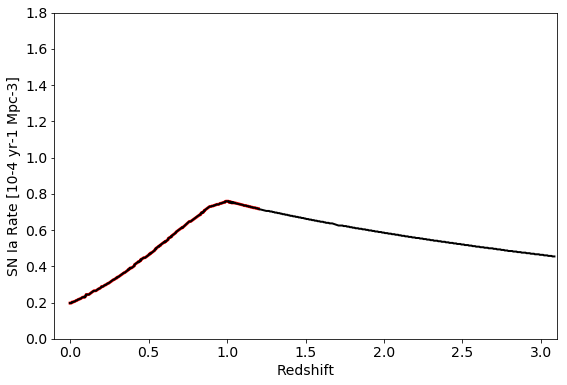

In [40]:
SNIa_data = pd.read_table('Graur_Fig213.dat', delimiter=', ')
redshift = SNIa_data['redshift'].values
rate = SNIa_data['SNIa_rate'].values

SNIa_rate_model = interpolate.interp1d(redshift,rate)

plt.xlabel('Redshift')
plt.ylabel('SN Ia Rate [10-4 yr-1 Mpc-3]')
plt.axis(xmin=-0.1, xmax=3.1, ymin=0.0, ymax=1.8)
plt.plot(z_sim, SNIa_rate_model(z_sim), color='r', lw=3)
plt.plot(redshift, rate, color='k', lw=2)
plt.show()

In [ ]:
c_light=299792.458   # in km/s
c_AA=299792458*1.0e10# in AA/s
alpha_IMF=1.35       # Salpeter IMF: Salpeter et al. 1955 ApJ 121: 161
fow_LSST=9.62        # field of view LSST in degrees^2
delta_omega=fow_LSST*(math.pi/180)**2      # field of view LSST in str
# calculating for r-band -> http://smtn-002.lsst.io/en/latest/
h_erg = 6.63e-27     # Planck constant (erg.s)
d_h=c_light/H0   # Hubble distance in Mpc   (70 km/s / Mpc)

## LSST filter responses

We load the LSST filter throughputs from https://github.com/lsst/throughputs/tree/master/baseline

In [36]:
import lsst.sims.photUtils.Bandpass as Bandpass

lsst={}
x_func={}
s_x={}
dem_x={}
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
lsst_effl={'u':3654.9,'g':4800.3,'r':6222.0,'i':7540.6,'z':8682.1,'y':9916.6}
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}

for f in filterlist:
    lsst[f] = Bandpass()
    lsst[f].readThroughput('total_'+f+'.dat')

    trans_file=np.loadtxt('total_'+f+'.dat')
    lambda_filter=trans_file[:,0]*10     #in AA
    s_x[f]=trans_file[:,1]
    x_func[f]=interpolate.interp1d(lambda_filter,s_x[f])
    dem_x[f]=integrate.simps(x_func[f](lambda_filter)*1.0/lambda_filter,lambda_filter) 

    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='LSST %s' % (f))

plt.xlabel('Wavelength [nm]')
plt.ylabel('Throughput [0-1]')
plt.title('LSST Throughput Curves')
plt.legend(loc=(0.85, 0.5), fancybox=True, fontsize='smaller')
plt.grid(True)
plt.savefig(os.path.join('LSSTfilters.png'), format='png')
plt.show()

ImportError: No module named lsst.sims.photUtils.Bandpass

## 1.2 K-corrections

We use [Hsiao et al. 2007](http://adsabs.harvard.edu/abs/2007ApJ...663.1187H) models to measure K-corrections between bands.

In [37]:
class Kcorrection(object):
    def __init__(self):
        self.array = np.empty((len(filterlist),len(filterlist),len(z_sim)))
        self.interpolate ={}
    
    def __getitem__(self,(f1,f2,z)):
        return self.array[filterlist.index(f1),filterlist.index(f2),z]

    def __setitem__(self,(f1,f2,z),value):
        self.array[filterlist.index(f1),filterlist.index(f2),z]=value
    
    def interpol(self,f1,f2):
        if f1+f2 not in self.interpolate:
            self.interpolate[f1+f2]=interpolate.interp1d(z_sim,self[f1,f2,:])  
        return self.interpolate[f1+f2]

In [38]:
#use Hsiao model at peak
ascii=pd.read_table('hsiao_SNIa_template/snflux_1a.dat',delim_whitespace=True,header=None)
epoch_peak = ascii[ascii[0] == 0.0]
lambda_model = epoch_peak[1].values
flux_model = epoch_peak[2].values

F_spec_model_0=interpolate.interp1d(lambda_model,flux_model)

Kcor=Kcorrection()
m_lsst_za={}
m_lsst_0={}
            
for i,zs in enumerate(z_sim):
    lambda_model_obs=lambda_model*(1+zs)
    flux_model_obs=flux_model/(1+zs)
    F_spec_model_z=interpolate.interp1d(lambda_model_obs,flux_model_obs)
    
    for f in filterlist:
        #comparison of F_spec_model_z and F_spec_model_0
        n_lsst_za=integrate.simps(F_spec_model_z(lambda_filter)*x_func[f](lambda_filter)*lambda_filter,lambda_filter)   
        m_lsst_za[f]=-2.5*(np.log10(n_lsst_za/dem_x[f]))-48.60+2.5*(np.log10(c_AA))
        #Comparison of F_spec_model_z(SDSS) and F_spec_model_0(CSP)
        n_lsst_0=integrate.simps(F_spec_model_0(lambda_filter)*x_func[f](lambda_filter)*lambda_filter,lambda_filter)   
        m_lsst_0[f]=-2.5*(np.log10(n_lsst_0/dem_x[f]))-48.60+2.5*(np.log10(c_AA))

    for j,f1 in enumerate(filterlist):
        for k,f2 in enumerate(filterlist):
            Kcor[f1,f2,i]=m_lsst_za[f1]-m_lsst_0[f2]

IOError: File hsiao_SNIa_template/snflux_1a.dat does not exist

## 1.3 Here we construct a K-correction term from all bands to r-band

In [ ]:
Kxr=np.zeros(len(z_sim))
for i,zs in enumerate(z_sim):
    #select the closest filter to r at a certain redshift
    lambda_eff=lsst_effl['r']*(1+zs)    
    ind_X = np.where(np.array(lsst_effl.values()) == find_nearest(lsst_effl.values(),lambda_eff) )[0][0]    
    Kxr[i]=Kcor[lsst_effl.keys()[ind_X],'r',i]

Kxr_func=interpolate.interp1d(z_sim,Kxr)

for j,f1 in enumerate(filterlist):
    plt.plot(z_sim,Kcor.interpol(f1,'r')(z_sim),filtercolors[f1])
plt.plot(z_sim,Kxr_func(z_sim),'black')
plt.xlabel('Redshift')
plt.ylabel('Kxr')
plt.ylim(-2,2)
plt.legend(('u->r','g->r','r->r','i->r','z->r','y->r'),loc=3,markerscale=0.5,prop={'size':15},ncol=2) 
plt.show()

#Final Kcorrections fron x to r in Kx_r and Kxr_func
# r->r if zs <= 0.105:
# i->r if zs > 0.105 and zs <= 0.303:
# z->r if zs > 0.303 and zs <= 0.494:
# y->r if zs > 0.494:

## Example with SN Ia 1994D

## At which redshift SN 1994D would not be detected with LSST?
We will first take SN Ia 1994D as a reference and assume that all SNe Ia are like 1994D. We simulate its r-band light curve at different redshifts and see that at z=0.39 it would be below the LSST detections limit


In [ ]:
z_cmb = 0.002614
err_z_cmb = 0.000030

SN_photo=pd.read_table('SNLS3year_JRK07_1994D.dat',delim_whitespace=True, header=0)

SN_epoch=SN_photo['MJD'][SN_photo['FLT'] == 'R'].values
mag_r=SN_photo['MAG'][SN_photo['FLT'] == 'R'].values
dmag_r=SN_photo['MAGERR'][SN_photo['FLT'] == 'R'].values

M_SN_r=mag_r-5*np.log10(d_lum_distri(z_cmb))-25
dM_SN_r=np.sqrt(dmag_r**2+(np.array(err_z_cmb)*(5*(1+np.array(z_cmb))*1.0/(np.array(z_cmb)*(1+np.array(z_cmb)*1.0/2)*np.log10(10))))**2)

m_sn=np.zeros(shape=(len(SN_epoch),len(z_sim)))
for t,snep in enumerate(SN_epoch):
    for z,zs in enumerate(z_sim):
        m_sn[t,z]=M_SN_r[t]+d_mod_distri(zs)+Kxr_func(zs)
for z,zs in enumerate(z_sim):
    plt.plot(SN_epoch,m_sn[:,z],c=RdYlBu_11_r.mpl_colors[int(11.0*(z/np.float(len(z_sim))))]) 
    if min(m_sn[:,z]) > mag_lim['r']:
        print('Not visible from z='+str(zs))
        break

plt.ylim(30,-5)
plt.axhline(mag_lim['r'], color='k', linestyle='--')
plt.xlabel('MJD [days]')
plt.ylabel('Apparent magnitude [mag]')
plt.title('SN 1994D at several redshifts')
plt.show()

plt.plot(SN_epoch,M_SN_r, linestyle='--') 
plt.ylim(np.max(M_SN_r)+0.2,np.min(M_SN_r)-0.2)
plt.title('SN 1994D')
plt.ylabel('Absolute magnitude [mag]')
plt.xlabel('MJD [days]')
plt.show()


# Tina's note: this is where I need to start up tomorrow

## How many SNe Ia (SN 1994D-like) would the LSST discover in 1 year?

First, we compare our $m(t,z)$ with $m_{lim}$ of the LSST camera to obtain $\Delta_{t}(z)$,  the probability of detecting (the peak of) a SN at a given redshift 

In [ ]:
t_min=[0]*len(z_sim)
t_max=[0]*len(z_sim)
t_max_2=[0]*len(z_sim)
delta_t_redshift=[0]*len(z_sim) #delta t corrected by redshift
epoch_model_z=[0]*len(SN_epoch)

for i,zs in enumerate(z_sim):
    epoch_model_z=SN_epoch*(1+zs)  #1+z factor for time dilation
    if min(m_sn[:,i][:])<mag_lim['r']:
        t_min[i]=epoch_model_z[min(np.where(m_sn[:,i] <= mag_lim['r'])[0])]
        o=set(np.where(epoch_model_z >= t_min[i])[0])   #index of the last t>t_min
        p=set(np.where(m_sn[:,i] <= mag_lim['r'])[0])        #index at which we see the SN
        q=(list(o-p))                                 #all the indeces where we see the peak
        if q == []:
            t_max[i]=epoch_model_z[max(np.where(m_sn[:,i]<=mag_lim['r'])[0])]
            delta_t_redshift[i]=t_max[i]-t_min[i]
        else:
            t_max[i]=epoch_model_z[min(q)]
            t_max_2[i]=epoch_model_z[max(q)]
            delta_t_redshift[i]=(t_max[i]-t_min[i])+(max(epoch_model_z)-t_max_2[i])#le SBO+ rest of curve

Now we estimate the number of detected SNe Ia per unit of redshift, $dN/dz$. From Equations 2 and 5 of Forster et al. (2006)

In [ ]:
dV_dz_dW=np.zeros(len(z_sim))

#############
survey_length=1.0   #in years
#############

dn_dz_Horiuchi=[0]*len(z_sim)   
dn_dz_Cole=[0]*len(z_sim)      
dn_dz_Madau=[0]*len(z_sim)      

for i,zs in enumerate(z_sim):
    dV_dz_dW[i]=(pow(r_com_distri(zs),2)*d_h*e_z_distri(zs))                 #dV(z) is the volume per unit redshift being surveyed

    #total observing time multiplied by the probability of detecting a SN
    dn_dz_Horiuchi[i]=SNR_Horiuchi(zs)/(1.+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)     #dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]=SNR_Cole(zs)/(1+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)          #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
    dn_dz_Madau[i]=SNR_Madau(zs)/(1+zs)*dV_dz_dW[i]*delta_omega*((delta_t_redshift[i])/365.25)*survey_length #In yr (SNR in yr)        #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
                               
    
plt.plot(z_sim,dn_dz_Horiuchi,'b',z_sim,dn_dz_Cole,'c',z_sim,dn_dz_Madau,'r')
plt.title('The number of detected SNe Ia per unit of redshift interval')
plt.xlabel('redshift')
plt.ylabel('num SN ')
plt.legend(('Horiuchi','Cole','Madau'))
plt.show()

# We integrate for all the redshift to have the number of SN 
print('Num. SNe Horiuchi: '+str(int(np.sum(dn_dz_Horiuchi))))
for i,zs in enumerate(z_sim):
    if dn_dz_Horiuchi[i] == 0.0:
        print('No SNe Ia from z='+str(zs))
        break
        
print('Num. SNe Cole:     '+str(int(np.sum(dn_dz_Cole))))
for i,zs in enumerate(z_sim):
    if dn_dz_Cole[i] == 0.0:
        print('No SNe Ia from z='+str(zs))
        break
        
print('Num. SNe Madau:     '+str(int(np.sum(dn_dz_Madau))))
for i,zs in enumerate(z_sim):
    if dn_dz_Madau[i] == 0.0:
        print('No SNe Ia from z='+str(zs))
        break


In [ ]:
##This loads all models in lam,flux_model
model=pd.read_table('hsiao_SNIa_template/snflux_1a.dat',delim_whitespace=True,header=None)
epoch=model[0].values
wavelength=model[1].values
flux=model[2].values

puta94D = pd.read_table('SNLS3year_JRK07_1994D.dat',delim_whitespace=True, header=0)
ep_94D =puta94D['MJD'][SN_photo['FLT'] == 'R'].values - 49432.161
mag_94D =puta94D['MAG'][SN_photo['FLT'] == 'R'].values
F_94D =interpolate.interp1d(ep_94D,mag_94D)

epoch_unique = np.unique(epoch)
epoch_unique = epoch_unique[(epoch_unique > min(ep_94D)) & (epoch_unique < max(ep_94D))]

mapp_94D = len(epoch_unique)*[0]
Mabs_94D = len(epoch_unique)*[0]
M_SN_F850LP = len(epoch_unique)*[0]
n_obs=integrate.simps(F_spec_model_z(lambda_filter)*x_func['r'](lambda_filter)*lambda_filter,lambda_filter)
m_obs_r=-2.5*np.log10(n_obs/dem_x['r'])-48.60+2.5*(np.log10(c_AA))
factor=10**(-0.4*(F_94D(epoch_unique[0])-m_obs_r))

for i, e in enumerate(epoch_unique):
    if i == 0:
        F_spec_model_z=interpolate.interp1d(wavelength[epoch == e], flux[epoch == e])
        n_obs=integrate.simps(F_spec_model_z(lambda_filter)*x_func['r'](lambda_filter)*lambda_filter,lambda_filter)
        m_obs_r=-2.5*np.log10(n_obs/dem_x['r'])-48.60+2.5*(np.log10(c_AA))
        factor=10**(-0.4*(F_94D(epoch_unique[0])-m_obs_r))
    #mangling
    F_spec_model_z=interpolate.interp1d(wavelength[epoch == e], flux[epoch == e]*factor)
    num=integrate.simps(F_spec_model_z(lambda_filter)*x_func['r'](lambda_filter)*lambda_filter,lambda_filter)
    mapp_94D[i]=-2.5*np.log10((num/dem_x['r']))-48.60+2.5*(np.log10(c_AA))
    Mabs_94D[i]=mapp_94D[i]-mu_LCDM(z_cmb)
    plt.plot(wavelength[epoch == e],flux[epoch == e]*factor,
             c=Greys_9.mpl_colors[int(9.0*(i/np.float(len(epoch_unique))))])

plt.xlim(1000,15000)
plt.show()

In [ ]:
m_sn_model=np.zeros(shape=(len(epoch_unique),len(z_sim)))
for i, snep in enumerate(epoch_unique):
    for t, zs in enumerate(z_sim):
        m_sn_model[i,t]=Mabs_94D[i]+d_mod_distri(zs)+Kxr_func(zs)

for i,zs in enumerate(z_sim):
    plt.plot(epoch_unique,m_sn_model[:,i],
             c=RdYlBu_11_r.mpl_colors[int(11.0*(i/np.float(len(z_sim))))]) #M_SN_r,)#
    if min(m_sn[:,i]) > mag_lim['r']:
        print('Not visible from z='+str(zs))
        break
#plt.ylim(np.max(m_sn_model)+0.2,np.min(m_sn_model)-0.2)
plt.ylim(30,0)
#plt.xlim(0.,450)
plt.axhline(mag_lim['r'], color='k', linestyle='--')
plt.xlabel('MJD [days]')
plt.ylabel('Apparent magnitude [mag]')
plt.title('Luc at several redshifts')
plt.show()

# 5. Example with a CSP-like simulated sample of SNe Ia

Finally, we will use a a sample of 10,000 SNe, generate using equation 12 of Strolger et al. 2004. We will put each at redshifts raning from 0.01 to 1.2.

In [ ]:
survey_length=1.0
num_SN = 2000

m_SN       = np.zeros((num_SN, len(z_sim), len(M_SN_r)))
delta_t_SN = np.zeros((num_SN, len(z_sim), len(M_SN_r)))

delta_M15 = np.random.normal(loc=1.1, scale=0.35, size=num_SN)
delta_m15 = 0.7 + 0.2*np.random.random(size=num_SN*0.2)
delta_m15 = np.append(delta_m15, 0.9 + 0.4*np.random.random(size=num_SN*0.6))
delta_m15 = np.append(delta_m15, 1.7 + 0.2*np.random.random(size=num_SN*0.2))
color_correction = 0.3*np.random.random(size=num_SN)

for i in range(num_SN):
    if (delta_M15[i] > 0.7) and (delta_M15[i] < 1.7):
        delta_M_peak = 0.786*(delta_m15[i] - 1.1) + 0.633*(delta_m15[i] - 1.1)**2.
    elif (delta_M15[i] > 1.7) and (delta_M15[i] < 2.2):
        delta_M_peak = 1.35 + 0.786*(delta_m15[i] - 1.1) + 0.633*(delta_m15[i] - 1.1)**2.
    else:
        delta_M_peak = np.nan
    for z in range(len(z_sim)):
        k_correction = Kxr_func(z_sim[z])
        luminosity_distance = 5.*np.log10(d_lum_distri(z_sim[z])) + 25.
        SN_photo = max(Mabs_94D) + delta_M_peak + color_correction[i] + luminosity_distance + k_correction
        m_SN[i, z, :] = SN_photo

In [ ]:
print np.nanmin(m_SN), np.nanmax(m_SN)
print np.shape(m_SN)
for i in range(num_SN):
    plt.plot(z_sim, m_SN[i,:,0].flatten(),alpha=0.9,linewidth=0.1,color='b')
plt.ylabel('Peak apparent magnitude [mag]')
plt.xlabel('Redshift')
#plt.ylim(np.max(m_SN[i,:,115])+0.2,np.min(m_SN[i,:,115])-0.2)
plt.ylim(30,18)
plt.show()

Here we measure $\Delta_t(z)$, selecting different magnitude limit depending on the filter we use for observations.

In [ ]:
for i, zs in enumerate(z_sim):
    wavelength_of_maxflux = 

for j in range((num_SN)):
    for i in range(len(z_sim)):
        if z_sim[i]<=0.3:           #V_swope would be converted to r_LSST                       
            if m_SN[j,i,121]<mag_lim['r']:
                delta_t_SN[j,i]=1.0
        elif (z_sim[i]>0.3) and (z_sim[i]<=0.57) :  #V_swope would be i_LSST
            if m_SN[j,i,121]<mag_lim['i']:
                delta_t_SN[j,i]=1.0
        elif (z_sim[i]>0.57) and (z_sim[i]<=0.78) : #V_swope would be z_LSST
            if m_SN[j,i,121]<mag_lim['z']:
                delta_t_SN[j,i]=1.0
        elif (z_sim[i]>0.78) :      #V_swope would be y_LSST
            if m_SN[j,i,121]<mag_lim['y']:
                delta_t_SN[j,i]=1.0

NOTE: this may be improved by carrying the distribution of delta_t_SN at each redshift, instead of simply measuring the average at each redshift

In [ ]:
delta_t_SN_tot=np.zeros((len(z_sim)))
for i in range(len(z_sim)):
    delta_t_SN_tot[i]=np.sum(delta_t_SN[:,i])

delta_t_SN_tot=delta_t_SN_tot/num_SN

In [ ]:
dV_dz_dW=np.zeros(len(z_sim))

dn_dz_Horiuchi=np.zeros(len(z_sim)) 
dn_dz_Cole=np.zeros(len(z_sim))
dn_dz_Madau=np.zeros(len(z_sim))

for i in range(len(z_sim)):
    dV_dz_dW[i]=(pow(r_com_LCDM(z_sim[i]),2)*d_h*e_z_LCDM(z_sim[i]))    #dV(z) is the volume per unit redshift being surveyed

    dn_dz_Horiuchi[i]=SNR_Horiuchi(z_sim[i])/(1+z_sim[i])*dV_dz_dW[i]*delta_omega*(delta_t_SN_tot[i]/365.25)*survey_length #In yr (SNR in yr)  #dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]    =SNR_Cole(z_sim[i])    /(1+z_sim[i])*dV_dz_dW[i]*delta_omega*(delta_t_SN_tot[i]/365.25)*survey_length #In yr (SNR in yr)  #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view
    dn_dz_Madau[i]   =SNR_Madau(z_sim[i])   /(1+z_sim[i])*dV_dz_dW[i]*delta_omega*(delta_t_SN_tot[i]/365.25)*survey_length #In yr (SNR in yr)  #dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view                               

z_sim,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau = zip(*sorted(zip(z_sim,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau)))

plt.plot(z_sim,np.array(dn_dz_Cole),'c',z_sim,np.array(dn_dz_Horiuchi),'b',z_sim,np.array(dn_dz_Madau),'r')
plt.title('The number of detected SNe Ia per unit of redshift interval')
plt.xlabel('redshift')
plt.ylabel('num SN ')
plt.legend(('Horiuchi','Cole','Madau'))
plt.show()

# We integrate for all the redshift to have the number of SN 
print('Num. SNe Horiuchi: '+str(int(np.sum(dn_dz_Horiuchi))))
print('Num. SNe Cole:     '+str(int(np.sum(dn_dz_Cole))))    
print('Num. SNe Madau:     '+str(int(np.sum(dn_dz_Madau))))
z_tot_Madau=[]
for i,zs in enumerate(z_sim):
    if dn_dz_Madau[i] == 0.0:
        print('No SNe Ia from z='+str(zs))
        break

z_sim,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau = zip(*sorted(zip(z_sim,dn_dz_Horiuchi,dn_dz_Cole,dn_dz_Madau)))
z_tot_Madau=[]
for i,zs in enumerate(z_sim):
    for j in range((int(round(dn_dz_Madau[i],0)))):
        z_tot_Madau.append(zs)

In [ ]:
data_save = np.column_stack((z_sims, dn_dz_Horiuchi, dn_dz_Cole, dn_dz_Madau))
np.savetxt("SNeIa_rates.dat", data_save, fmt="%.9e", header = "number of detected SNeII per unit of redshift interval \n z_random \t dn_dz_Horiuchi dn_dz_Cole \t dn_dz_Madau")

We have found the shape of the distribution, below one can create the final distribution by giving the total number of SNe II (with no selection effects) that LSST is supposed to found

In [ ]:
N_SNe_HD=input("Number of SNe for the Hubble diagram: ")
z_SNe_HD=np.random.choice(z_tot_Madau, N_SNe_HD, replace=True)

plt.hist(z_SNe_HD,color='blue',alpha=0.9,label='Single-visit')
plt.legend(loc=1,markerscale=0.5,prop={'size':12},ncol=2)
#plt.xlim(0,1.2)
plt.xlabel('redshift')
plt.ylabel('SN ')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.savefig('LSST_distribution.png')
plt.show()
